In [2]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./1D-difusion')

from aspen import aspen
from newton import newton

import partion

from one_phase import one_phase
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

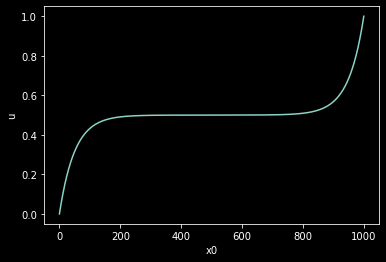

In [4]:
plt.style.use('dark_background')
# inital condition
Nx = 1000
Nt = 100

D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
bd1 = 0
bd2 = 1

x0 = np.arange(Nx)/(Nx-1)
x0 = np.sinh(20*(x0-0.5))
x0 /= np.max(x0)
x0 = (x0+1)/2
x0 = np.reshape(x0, (-1, 1))
plt.xlabel('x0')
plt.ylabel('u')
plt.plot(x0)

setInitial = lambda x: x#.setInitial(0.2, 1, 1) 
setSources = lambda x: x#.setSources([0.9], [-17.9])

In [6]:
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
t_new = np.inf
for k in range(4):
    nl_solver = newton(1e-2, kmax = 14, crit_abs = 1e-3)
    solver_cl = one_phase(param, D, nl_solver)
    solver_cl.init_log()
    solver_cl.setBoundary(bd1, bd2)
    solver_cl.x0 = np.copy(x0)
    #setInitial(solver_cl)
    setSources(solver_cl)

    X_cl, code, message = solver_cl.solve()
    t_new += solver_cl.timelog.res+solver_cl.timelog.jac \
      +solver_cl.timelog.lin
    
t_new /= 4
print(message)
print('mean newton iterations: ', np.mean(solver_cl.timelog.kn))
print('best time:', t_new)

newton log initialized


KeyboardInterrupt: 

In [ ]:
# we treet the value in time at particular coord as a variable
# let's visualize the covariance matrix of these varibles

cov_m = np.cov(X_cl)
cs = plt.matshow(cov_m)
cbar = plt.colorbar(cs)
plt.show()

cs = plt.matshow(np.abs(cov_m))
cbar = plt.colorbar(cs)
plt.show()

In [6]:
# hm...

def block_pnorm(m_cov, borders):
    N = m_cov.shape[0]
    nd = borders.shape[0]-1
    val = 0
    for i in range(1, nd):
        start = borders[i-1]
        end = borders[i]
        val += np.sum(m_cov[start:end, start:end]**2)\
            /(np.sum(m_cov[end:, start:end]**2)+np.sum(m_cov[start:end, end:]**2))
    val
    return val

def neighbour(domain_borders):
    nd = domain_borders.shape[0]-1
    neig = np.copy(domain_borders)
    for i in range(1, nd):
        bd = neig[i]
        left = (bd-1 != neig[i-1])
        right = (bd+1 != neig[i+1])
        
        if left and right:
            neig[i] += np.random.randint(-1, 1)
        elif left:
            neig[i] += np.random.randint(-1, 0)
        elif right:
            neig[i] += np.random.randint(0, 1)
            
    return neig

In [35]:
# start value
Nd = 4
part = partion.partion_equally(Nx, Nd)
print(part)
borders = np.copy(part)

T0 = 19600
val_start = -block_pnorm(cov_m, borders)
val_prev = np.copy(val_start)
for k in range(1, 4500, 5):
    T = T0/np.exp(0.1*k)
    borders_new = neighbour(borders)
    val = -block_pnorm(cov_m, borders_new)
    if (val < val_prev) or (np.random.rand() < np.exp(-(val-val_prev)/(T))):
        borders = np.copy(borders_new)
        val_prev = np.copy(val)

        
val_end = -block_pnorm(cov_m, borders)
print('before: {:.2E}'.format(val_start))
print('after: {:.2E}'.format(val_end))
if(val_start > val_end):
    print('it works!')
print(borders)

[   0  250  500  750 1000]
before: -5.74E-01
after: -5.95E-01
it works!
[   0   52  406  732 1000]


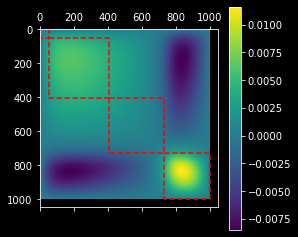

In [36]:
cs = plt.matshow(cov_m)
cbar = plt.colorbar(cs)
for i in range(1, Nd+1):
    start = borders[i-1]
    end = borders[i]
    plt.plot([start, end, end, start, start],
             [start, start, end, end, start],
             linestyle='--', color='r')
plt.show()

In [37]:
t_1 = np.inf

for k in range(5):
    nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
    solver_1 = one_phase(param, D, nl_solver)
    solver_1.init_log()
    solver_1.setBoundary(bd1, bd2)
    solver_1.x0 = np.copy(x0)
    #setInitial(solver_as)
    
    setSources(solver_1)
    X, code, message = solver_1.solve()
    t = solver_1.timelog.gb_res+solver_1.timelog.gb_jac \
      +solver_1.timelog.gb_lin+np.sum(solver_1.timelog.lc_res) \
      +np.sum(solver_1.timelog.lc_jac)+np.sum(solver_1.timelog.lc_lin)
    if t < t_1:
        t_1 = np.copy(t) 
print(message)
print('mean aspen iterations: ', np.mean(solver_1.timelog.aspen_iters))
print('best time:', t_1)

ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
ASPEN log initialized
OK
mean aspen iterations:  1.99
best time: 73.80619478225708
